## Downloading the jp2 file section

In [2]:
import gdown
import os

url  = "https://drive.google.com/file/d/1Hb7Lgo5vtbAtr36fq6knylSiATlJRDS6/view?usp=share_link"
output = "./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2"


model_url = "https://drive.google.com/file/d/1SbSArI3KOOWHxRlxnjchO7_MbWzB4lNR/view"
model_output = "hovernet_fast_pannuke_type_tf2pytorch.tar"


storage_dir = "./storage"

if not os.path.exists(storage_dir + "/jp2cache"):
    os.makedirs(storage_dir + "/jp2cache")

In [ ]:
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

## Model checkpoint

In [ ]:
gdown.download(url=model_url, output=model_output, quiet=False, fuzzy=True)

In [ ]:
!ls

## Importing the neccesary libs to access the jp2 file

In [3]:
from jp2tileaccesor.multi_res_Tiling import SectionProxy, TileAccessor, Span

In [4]:
proxy_lossless = SectionProxy(15, "NISSL", 1708)

print(proxy_lossless)

{'id': 5944, 'position_index': 1708, 'jp2Path': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2', 'pngPathLow': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_thumbnail.jpg', 'width': 81590, 'height': 83590, 'series': 10, 'rigidrotation': 90, 'notes': None}{'brainid': 15, 'seriesType': 'NISSL', 'secnumber': 1708, 'modes': {'jp2': False, 'iip': True, 'mmap': False, 'tif': False}}


In [5]:
proxy_lossless.check_local_jp2()

./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2


True

In [6]:
Image_size = 256
size = Span(Image_size,Image_size)
accessor = TileAccessor(proxy_lossless, 0, tilespan = size, use_iip = False)
print(accessor)

{'proxy': "{'id': 5944, 'position_index': 1708, 'jp2Path': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2', 'pngPathLow': '/data/storageIIT/humanbrain/analytics/37/NISL/B_37_FB3-SL_570-ST_NISL-SE_1708_thumbnail.jpg', 'width': 81590, 'height': 83590, 'series': 10, 'rigidrotation': 90, 'notes': None}{'brainid': 15, 'seriesType': 'NISSL', 'secnumber': 1708, 'modes': {'jp2': True, 'iip': True, 'mmap': False, 'tif': False}}", 'resolution': 0, 'imagespan': Span(w=81590, h=83590), 'tilespan': Span(w=256, h=256), 'ntiles': 104313, 'ntiles_c': 319, 'ntiles_r': 327}


In [7]:
import os
from PIL import Image
import numpy as np
import tensorrt
import onnx
import gc
import models.hovernet.net_desc as net
import torch
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
Image_size = 256
def check_make_dir(path_dir):
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


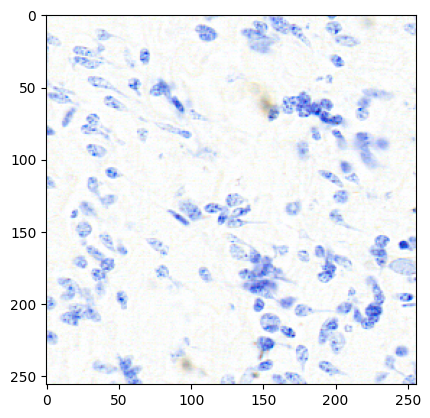

In [8]:
tile = accessor[np.random.randint(accessor.ntiles)]
plt.imshow(tile[0])

In [8]:
accessor[np.random.randint(accessor.ntiles)][0].shape

(256, 256, 3)

* Randomly sampling the images to make a dataset to test all models on.
* Tiles are selected at random because continous selection can lead to rows of tiles which do not contain brain matter.

In [ ]:
num_tiles = 1024
t=0
check_make_dir(storage_dir + "/cache_" + str(Image_size))

for i in range(0,accessor.ntiles):
    if t >= num_tiles:
        break
    tile = accessor[np.random.randint(accessor.ntiles)]
    if tile[0].shape == (256, 256, 3):
        plt.imsave(storage_dir+"/cache_"+str(Image_size) + "/"+str(i)+".png",tile[0])
        t+=1

In [9]:
file_list = os.listdir(storage_dir+"/cache_"+str(Image_size))
print("Number of Images",len(file_list))
pics = [ storage_dir + "/cache_"+str(Image_size) + "/" +str(i) for i in file_list]

Number of Images 1029


In [10]:
import numpy as np
np_pics = np.asarray(Image.open(pics[0]))
brain_tiles = np_pics.reshape(1,4,Image_size,Image_size)
for i in range(len(pics)-1):
    img = np.asarray(Image.open(pics[i+1]))
    if (img.shape == (256, 256, 4)):
        brain_tiles = np.concatenate((brain_tiles,img.reshape(1,4,Image_size,Image_size)),axis=0)
    

In [11]:
brain_tiles = torch.from_numpy(brain_tiles).float()

In [12]:
brain_tiles = brain_tiles[:1024,:3,:,:]

In [13]:
brain_tiles.shape

torch.Size([1024, 3, 256, 256])

## Importing the original Hovernet model

In [9]:
from run_utils.utils import convert_pytorch_checkpoint
model_path = 'hovernet_fast_pannuke_type_tf2pytorch.tar'
hovernet = net.HoVerNet(nr_types = 6,mode='fast')
saved_state_dict = torch.load(model_path)["desc"]
saved_state_dict = convert_pytorch_checkpoint(saved_state_dict)

hovernet.load_state_dict(saved_state_dict, strict=True)
hovernet = torch.nn.parallel.DataParallel(hovernet)
hovernet = hovernet.to("cuda")
hovernet.eval()

DataParallel(
  (module): HoVerNet(
    (conv0): Sequential(
      (pad): TFSamepaddingLayer()
      (/): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (d0): ResidualBlock(
      (units): ModuleList(
        (0): Sequential(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (conv1/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1/relu): ReLU(inplace=True)
          (conv2/pad): TFSamepaddingLayer()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (conv2/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2/relu): ReLU(inplace=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): Sequential(
          (p

## Timing the model

* model.forward is executed on a given batch size for a given dataset size and during the run gpu resources are monitored and the timing of each call is averaged over 3 calls done with the same images.

In [ ]:
%%capture
import numpy as np
import nvidia_smi
nvidia_smi.nvmlInit()
results_run = {}
results_time_in = {}
results_time_out = {}
results_time_load = {}
results_time_gpu = {}
Batch_sizes = [1,2,4,8,16]

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
brain_tiles_cuda = brain_tiles.to('cuda')
for j in Batch_sizes:
    res = []
    res2 = []
    res3 = []
    res4 = []
    res_gpu = []
    res_mem = []
    res_pwr = []
    batch_size = j
    for i in range(0,brain_tiles_cuda.shape[0],batch_size):
        temp = %timeit -n1 -r3 -o hovernet.forward(brain_tiles_cuda[i:i+batch_size,:,:,:])
        res.append(temp)
        g = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
        p = nvidia_smi.nvmlDeviceGetPowerUsage(handle)
        res_gpu.append(g.gpu)
        res_mem.append(g.memory)
        res_pwr.append(p/1000)
        torch.cuda.empty_cache()
        gc.collect()

    a=0
    b=0
    w=0
    for i in res:
        a+=i.average
        b+=i.best
        w+=i.worst
    results_run[j] = (a,b,w)
    results_time_load[j] = (a,b,w)
    results_time_gpu[j] = (res_gpu,res_mem,res_pwr)

In [ ]:
results_run

In [ ]:
plt.title("GPU utilization")
plt.ylabel("%")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][0][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

In [ ]:
plt.title("VRAM utilization")
plt.ylabel("%")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][1][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

In [ ]:
plt.title("Power Draw")
plt.ylabel("Watts")
for i in Batch_sizes:
    plt.plot(results_time_gpu[i][2][20:200],label = "batch" + str(i))
    plt.legend()
    
plt.grid()
plt.show()

In [ ]:
i=40
out = hovernet.forward(brain_tiles[i:i+1,:,:,:])
out = out.cpu()
import matplotlib.pyplot as plt
fig , axs = plt.subplots(5,2,figsize=(12,15))
k=0
plt.axis('off')
count = 0
for i in range(5):
    for j in range(2):
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        axs[i,j].imshow(out[0,k,:,:].detach().numpy())
        axs[i,j].title.set_text( str(k) + " channel ")
        k+=1

## Exporting the model to onnx Format using pytorch onnx export

In [18]:
size = 256
batch = 0

In [19]:
dummy_input = torch.empty(batch,3,size,size)
onnx_name = "./onnx_export/hovernet_" + str(size) + "_" + str(batch) + ".onnx"
check_make_dir("./onnx_export/")
dummy_input = dummy_input.to('cuda')

In [20]:
dummy_input.dtype

torch.float32

In [21]:
torch.onnx.export(hovernet.module,dummy_input,onnx_name,export_params=True)

torch.cuda.empty_cache()
gc.collect()

0

In [23]:
!ls ./onnx_export

hovernet_256_0.onnx    hovernet_256_16_best.plan  hovernet_256_32.onnx
hovernet_256_128.onnx  hovernet_256_192.onnx	  hovernet_256_64.onnx
hovernet_256_16.onnx   hovernet_256_256.onnx


## Exporting model to plan file to load in TensorRT

In [ ]:
!trtexec --onnx="./onnx_export/hovernet_256_16.onnx" --saveEngine="hovernet_256_16_best.plan" --buildOnly --best --precisionConstraints=prefer

## Running model in TensorRT

In [19]:
!ls | grep .plan

hovernet_256_16_best.plan
hovernet_256_64_best.plan


In [20]:
import TensorRT.inference as inf
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

In [21]:
TRT_LOGGER = trt.Logger(min_severity =trt.ILogger.INTERNAL_ERROR)
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())


In [22]:
engine_files = {64 : ["hovernet_256_64_best.plan"]}

In [1]:
%%capture
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit 
import nvidia_smi
nvidia_smi.nvmlInit()

results_run_engine = {}
results_time_in = {}
results_time_out = {}
results_time_load = {}
results_time_gpu_engine = {}
Batch_sizes = [64]

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        
        res = []
        res2 = []
        res3 = []
        res4 = []
        res_gpu = []
        res_mem = []
        res_pwr = []
        engine = load_engine(path_plan)
        h_input_1, d_input_1, h_output, d_output, stream = inf.allocate_buffers(engine,1,trt.float32)
        with engine.create_execution_context() as context:
            
            for i in range(0,brain_tiles.shape[0],batch_size):
                temp = %timeit -n1 -r1 -o inf.load_images_to_buffer(brain_tiles[i:i+batch_size,:,:,:], h_input_1)
                res4.append(temp)
                temp = %timeit -n1 -r1 -o cuda.memcpy_htod_async(d_input_1, h_input_1, stream)
                res2.append(temp)
                temp = %timeit -n1 -r3 -o context.execute_v2(bindings=[int(d_input_1), int(d_output)])
                res.append(temp)
                temp = %timeit -n1 -r1 -o cuda.memcpy_dtoh_async(h_output, d_output, stream)
                res3.append(temp)
                g = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
                p = nvidia_smi.nvmlDeviceGetPowerUsage(handle)
                res_gpu.append(g.gpu)
                res_mem.append(g.memory)
                res_pwr.append(p/1000)

            a=0
            b=0
            w=0
            for i in res:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_run_engine[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res2:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_in[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res3:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_out[path_plan] = (a,b,w)

            a=0
            b=0
            w=0
            for i in res4:
                a+=i.average
                b+=i.best
                w+=i.worst
            results_time_load[path_plan] = (a,b,w)
            results_time_gpu_engine[path_plan] = (res_gpu,res_mem,res_pwr)

NameError: name 'engine_files' is not defined

In [25]:
results_run_engine

{'hovernet_256_64_best.plan': (3.0267165728534264,
  2.9973021135665476,
  3.0767937512136996)}

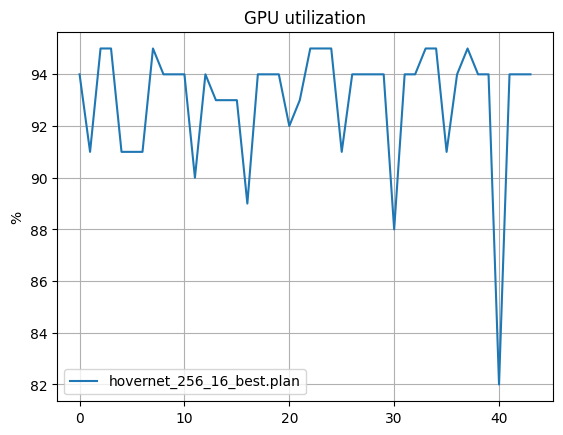

In [21]:
plt.title("GPU utilization")
plt.ylabel("%")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][0][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

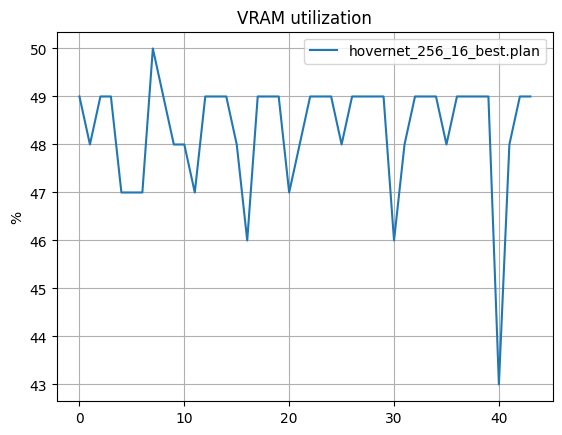

In [22]:
plt.title("VRAM utilization")
plt.ylabel("%")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][1][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

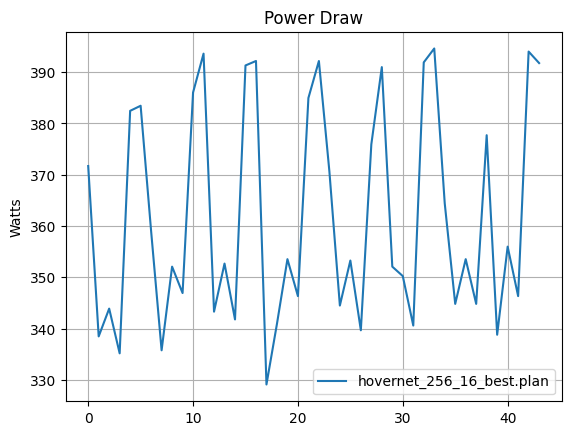

In [23]:
plt.title("Power Draw")
plt.ylabel("Watts")
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        plt.plot(results_time_gpu_engine[path_plan][2][20:200],label = path_plan)
        plt.legend()
    
plt.grid()
plt.show()

## Comparing the outputs

In [ ]:
check_pic = brain_tiles[:64,:,:,:]
check_pic_cuda = check_pic.to('cuda')

In [ ]:
outputs = {}

In [ ]:
def visualize_channel(out,img_no = 0):
    fig , axs = plt.subplots(5,2,figsize=(12,15))
    k=0
    plt.axis('off')
    count = 0
    for i in range(5):
        for j in range(2):
            axs[i,j].xaxis.set_visible(False)
            axs[i,j].yaxis.set_visible(False)
            t = axs[i,j].imshow(outputs[name][img_no,k,:,:])
            plt.colorbar(t)
            axs[i,j].title.set_text( str(k) + " channel ")
            k+=1

In [ ]:
name = "hovernet_original"
check_pic = check_pic.to('cuda')
outputs[name] = hovernet.forward(check_pic[:16]).cpu()
for i in range(16,check_pic.shape[0],batch_size):
    outputs[name] = np.concatenate((outputs[name],hovernet.forward(check_pic[i:i+16]).cpu()),axis=0)
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
outputs[name].shape

In [ ]:
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit 

Batch_sizes = [8,16]
height = 164
width = 164
check_pic = check_pic.to('cpu')
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        engine = load_engine(path_plan)
        h_input_1, d_input_1, h_output, d_output, stream = inf.allocate_buffers(engine,1,trt.float32)
        with engine.create_execution_context() as context:
            for i in range(0,check_pic.shape[0],batch_size):
                inf.load_images_to_buffer(check_pic[i:i+batch_size,:,:,:], h_input_1)
                cuda.memcpy_htod_async(d_input_1, h_input_1, stream)
                context.execute_v2(bindings=[int(d_input_1), int(d_output)])
                cuda.memcpy_dtoh_async(h_output, d_output, stream)
                stream.synchronize()
                if(path_plan in outputs.keys()):
                    outputs[path_plan] = np.concatenate((outputs[path_plan],(h_output.reshape((batch_size,-1, height, width)))),axis=0)
                else:
                    outputs[path_plan] = h_output.reshape((batch_size,-1, height, width))
                

In [ ]:
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        print(path_plan,outputs[path_plan].shape)

In [ ]:
visualize_channel(outputs['hovernet_256_8_TF32.plan'],40)

In [ ]:
visualize_channel(outputs['hovernet_original'],40)

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.special import softmax

In [ ]:
def post_proc(output):
    return softmax(output[...][:,6:8,:,:], axis=1)[..., 1]

In [ ]:
for j in Batch_sizes:
    batch_size = j
    for path_plan in engine_files[j]:
        print(path_plan," PSNR Score ")
        print(psnr(post_proc(outputs['hovernet_original']),post_proc(outputs[path_plan]),data_range = 1))